In [500]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from utils import calculate_metrics

In [501]:
loss_o_automatic = []
loss_o_shallow = []
loss_o_deep = []
loss_r_automatic = []
loss_r_shallow = []
loss_r_deep = []

In [502]:
accuracy_o_automatic = []
accuracy_o_shallow = []
accuracy_o_deep = []
accuracy_r_automatic = []
accuracy_r_shallow = []
accuracy_r_deep = []

# Original Dataset

In [503]:
# Load the data
df = pd.read_csv('../../data/processed/heart_se.csv')

In [504]:
# Split the data into features and target variable
X = df.drop(['target','index'], axis=1)
y = df['target']

# Split the dataset into training and testing sets
# Assuming X and y are your full dataset
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)




In [505]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## Automatic Tuning

In [506]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int('n_layers', 1, 10)
    layers = []
    input_size = X_train.shape[1]
    
    for i in range(n_layers):
        num_hidden_units = trial.suggest_int(f'n_units_l{i}', 1, 128)
        layers.append(nn.Linear(input_size, num_hidden_units))
        layers.append(nn.ReLU())
        input_size = num_hidden_units
    
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())  # Assuming binary classification
    
    model = nn.Sequential(*layers)
    
    # Suggest optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD', 'Adadelta', 'Adagrad', 'AdamW'])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    # Define loss function
    criterion = nn.BCELoss()
    
    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch).squeeze()
            predicted = (outputs > 0.5).float()
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()
    
    val_accuracy = val_correct / val_total
    return val_accuracy

# Optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# After the study is done, evaluate the best model on the test set
best_trial = study.best_trial

print("Best trial:")
print(f"  Validation Accuracy: {best_trial.value}")
print("  Best hyperparameters: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2024-08-30 11:39:20,562] A new study created in memory with name: no-name-823d7525-0180-451b-b9cb-60e01e8fa503
/var/folders/y0/8vyv832s3696sxgrt2_3v0k40000gn/T/ipykernel_70212/3850794974.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-08-30 11:39:20,741] Trial 0 finished with value: 0.47540983606557374 and parameters: {'n_layers': 3, 'n_units_l0': 67, 'n_units_l1': 13, 'n_units_l2': 23, 'optimizer': 'Adadelta', 'lr': 0.0007879345826584961}. Best is trial 0 with value: 0.47540983606557374.
[I 2024-08-30 11:39:20,861] Trial 1 finished with value: 0.819672131147541 and parameters: {'n_layers': 3, 'n_units_l0': 84, 'n_units_l1': 54, 'n_units_l2': 81, 'optimizer': 'Adam', 'lr': 0.008037014011100853}. Best is trial 1 with value: 0.819672131147541.
[I 2024-08-30 11:39:21,014] Trial 2 finished with value: 0.524590163934

Best trial:
  Validation Accuracy: 0.8852459016393442
  Best hyperparameters: 
    n_layers: 1
    n_units_l0: 12
    optimizer: Adam
    lr: 0.0007797008315149961


In [507]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()



In [508]:
import plotly.graph_objects as go
import optuna
from optuna.importance import get_param_importances

# Convert dict_keys to a list
param_importance = plot_param_importances(study, params=list(study.best_params.keys()))
param_importance.show()

In [509]:
# Extract the best number of layers
best_n_layers = study.best_trial.params['n_layers']

# Filter the trials to create a new study object with only relevant trials
filtered_trials = [t for t in study.trials if t.params['n_layers'] == best_n_layers]

# Create a new study object with the filtered trials
filtered_study = optuna.create_study(direction='maximize')
for trial in filtered_trials:
    filtered_study.add_trial(trial)

# Generate the parallel coordinate plot for the filtered study
parallel_coordinate = plot_parallel_coordinate(filtered_study)
parallel_coordinate.show()

[I 2024-08-30 11:40:11,277] A new study created in memory with name: no-name-0afab282-297a-4acb-83c5-7a2fbbf28aeb


In [510]:
# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

In [511]:
# confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
import numpy

# Extract the best trial
best_trial = study.best_trial

# Extract the best hyperparameters
best_n_layers = best_trial.params['n_layers']
best_layers = [best_trial.params[f'n_units_l{i}'] for i in range(best_n_layers)]
best_optimizer = best_trial.params['optimizer']
best_lr = best_trial.params['lr']

# Define the model using the best hyperparameters
layers = []
input_size = X_train.shape[1]
for num_hidden_units in best_layers:
    layers.append(nn.Linear(input_size, num_hidden_units))
    layers.append(nn.ReLU())
    input_size = num_hidden_units
    
layers.append(nn.Linear(input_size, 1))
layers.append(nn.Sigmoid())
model = nn.Sequential(*layers)

# Define the optimizer
optimizer = getattr(optim, best_optimizer)(model.parameters(), lr=best_lr)

# Define the loss function
criterion = nn.BCELoss()

losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    losses_train.append(running_loss / len(train_loader))
    accuracies_train.append(correct / total)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        
        losses_test.append(running_loss / len(test_loader))
        accuracies_test.append(correct / total)

accuracy_o_automatic = accuracies_test.copy()

#plot training and validation loss and accuracy with plotly
import plotly.graph_objects as go

loss_o_automatic = losses_train.copy()

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_train, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_test, mode='lines', name='Validation Accuracy'))

fig.update_layout(
    title='Accuracy Curves',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_train, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_test, mode='lines', name='Validation Loss'))

fig.update_layout(
    title='Loss Curves',
    xaxis_title='Epoch',
    yaxis_title='Loss',
)

fig.show()





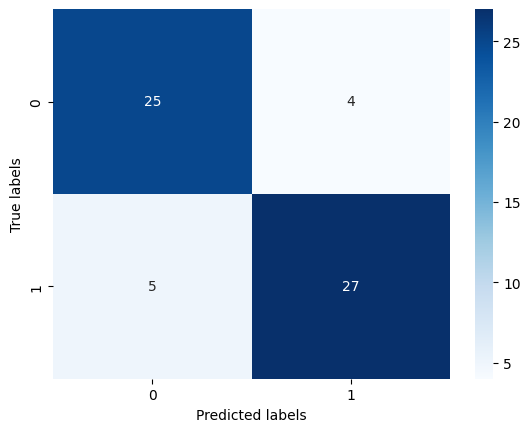

In [512]:
#plot confusion matrix with seaborn blue
import seaborn as sns
import matplotlib.pyplot as plt

# Test loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [513]:
# Print classification report
print(classification_report(y_true, y_pred, target_names=['less', 'more']))


              precision    recall  f1-score   support

        less       0.83      0.86      0.85        29
        more       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



# Hand tuning

### Shallow

In [514]:

# Define the model using the best hyperparameters
layers = []
input_size = X_train.shape[1]

layers.append(nn.Linear(input_size, 27*2))
layers.append(nn.ReLU())
layers.append(nn.Linear(27*2, 1))
layers.append(nn.Sigmoid())

model = nn.Sequential(*layers)

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Define the loss function
criterion = nn.BCELoss()

losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    losses_train.append(running_loss / len(train_loader))
    accuracies_train.append(correct / total)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        
        losses_test.append(running_loss / len(test_loader))
        accuracies_test.append(correct / total)
    

accuracy_o_shallow = accuracies_test.copy()
#plot training and validation loss and accuracy with plotly
import plotly.graph_objects as go

loss_o_shallow = losses_train.copy()

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_train, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_test, mode='lines', name='Validation Accuracy'))

fig.update_layout(
    title='Accuracy Curves',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_train, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_test, mode='lines', name='Validation Loss'))

fig.update_layout(
    title='Loss Curves',
    xaxis_title='Epoch',
    yaxis_title='Loss',
)

fig.show()






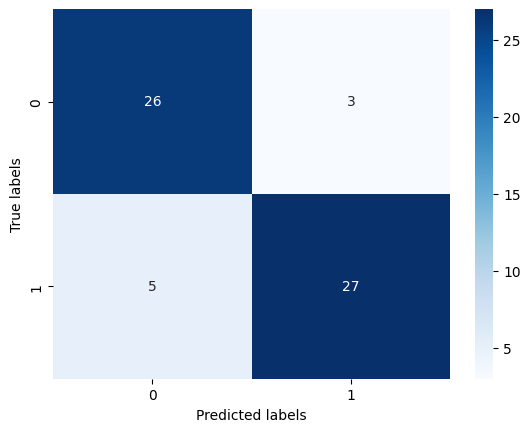

In [515]:

# Test loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [516]:
# Print classification report
print(classification_report(y_true, y_pred, target_names=['less', 'more']))

              precision    recall  f1-score   support

        less       0.84      0.90      0.87        29
        more       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



### Deep

In [517]:

# Define the model using the best hyperparameters
layers = []
input_size = X_train.shape[1]

layers.append(nn.Linear(input_size, 10))
layers.append(nn.ReLU())
layers.append(nn.Linear(10, 3))
layers.append(nn.ReLU())
layers.append(nn.Linear(3, 10))
layers.append(nn.ReLU())
layers.append(nn.Linear(10, 1))
layers.append(nn.Sigmoid())

model = nn.Sequential(*layers)

# Define the optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

# Define the loss function
criterion = nn.BCELoss()

losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []

# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    losses_train.append(running_loss / len(train_loader))
    accuracies_train.append(correct / total)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        
        losses_test.append(running_loss / len(test_loader))
        accuracies_test.append(correct / total)

accuracy_o_deep = accuracies_test.copy()
#plot training and validation loss and accuracy with plotly
import plotly.graph_objects as go

loss_o_deep = losses_train.copy()
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_train, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_test, mode='lines', name='Validation Accuracy'))

fig.update_layout(
    title='Accuracy Curves',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_train, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_test, mode='lines', name='Validation Loss'))

fig.update_layout(
    title='Loss Curves',
    xaxis_title='Epoch',
    yaxis_title='Loss',
)

fig.show()


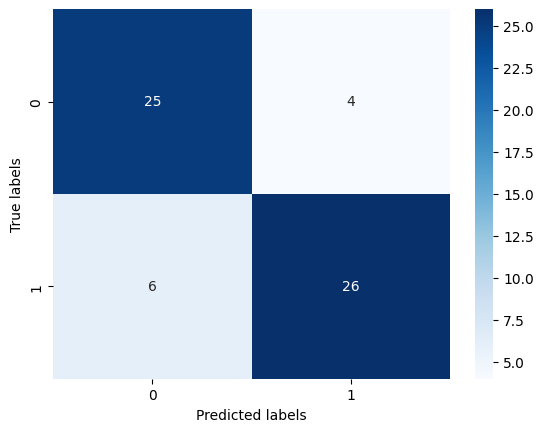

In [518]:

# Test loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [519]:
# Print classification report
print(classification_report(y_true, y_pred, target_names=['less', 'more']))

              precision    recall  f1-score   support

        less       0.81      0.86      0.83        29
        more       0.87      0.81      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



In [520]:
calculate_metrics(y_true, y_pred, 'nn')

Metrics saved to ./results/original/nn


# balanced

In [521]:
# Load the data
df_train = pd.read_csv('../../data/processed/resampled/heart_resampled_train_se.csv')
df_test = pd.read_csv('../../data/processed/resampled/heart_resampled_test_se.csv')

In [522]:
# Split the data into features and target variable
X_train = df_train.drop(['target','index'], axis=1)
y_train = df_train['target']
X_test = df_test.drop(['target','index'], axis=1)
y_test = df_test['target']


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)




In [523]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## Automatic Tuning

In [524]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int('n_layers', 1, 10)
    layers = []
    input_size = X_train.shape[1]
    
    for i in range(n_layers):
        num_hidden_units = trial.suggest_int(f'n_units_l{i}', 1, 128)
        layers.append(nn.Linear(input_size, num_hidden_units))
        layers.append(nn.ReLU())
        input_size = num_hidden_units
    
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())  # Assuming binary classification
    
    model = nn.Sequential(*layers)
    
    # Suggest optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD', 'Adadelta', 'Adagrad', 'AdamW'])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    # Define loss function
    criterion = nn.BCELoss()
    
    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch).squeeze()
            predicted = (outputs > 0.5).float()
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()
    
    val_accuracy = val_correct / val_total
    return val_accuracy

# Optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# After the study is done, evaluate the best model on the test set
best_trial = study.best_trial

print("Best trial:")
print(f"  Validation Accuracy: {best_trial.value}")
print("  Best hyperparameters: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2024-08-30 11:40:12,951] A new study created in memory with name: no-name-6d982624-9a86-4405-b4e7-ce6a7262658d
/var/folders/y0/8vyv832s3696sxgrt2_3v0k40000gn/T/ipykernel_70212/3850794974.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-08-30 11:40:13,118] Trial 0 finished with value: 0.7727272727272727 and parameters: {'n_layers': 4, 'n_units_l0': 64, 'n_units_l1': 38, 'n_units_l2': 40, 'n_units_l3': 122, 'optimizer': 'AdamW', 'lr': 0.0001496711185073031}. Best is trial 0 with value: 0.7727272727272727.
[I 2024-08-30 11:40:13,251] Trial 1 finished with value: 0.4696969696969697 and parameters: {'n_layers': 3, 'n_units_l0': 15, 'n_units_l1': 23, 'n_units_l2': 113, 'optimizer': 'Adadelta', 'lr': 0.005397934938109213}. Best is trial 0 with value: 0.7727272727272727.
[I 2024-08-30 11:40:13,439] Trial 2 finished with 

Best trial:
  Validation Accuracy: 0.8484848484848485
  Best hyperparameters: 
    n_layers: 4
    n_units_l0: 21
    n_units_l1: 84
    n_units_l2: 73
    n_units_l3: 68
    optimizer: Adam
    lr: 0.00033546580623547515


In [525]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()



In [526]:
import plotly.graph_objects as go
import optuna
from optuna.importance import get_param_importances

# Convert dict_keys to a list
param_importance = plot_param_importances(study, params=list(study.best_params.keys()))
param_importance.show()

In [527]:
# Extract the best number of layers
best_n_layers = study.best_trial.params['n_layers']

# Filter the trials to create a new study object with only relevant trials
filtered_trials = [t for t in study.trials if t.params['n_layers'] == best_n_layers]

# Create a new study object with the filtered trials
filtered_study = optuna.create_study(direction='maximize')
for trial in filtered_trials:
    filtered_study.add_trial(trial)

# Generate the parallel coordinate plot for the filtered study
parallel_coordinate = plot_parallel_coordinate(filtered_study)
parallel_coordinate.show()

[I 2024-08-30 11:42:01,026] A new study created in memory with name: no-name-2be3bacf-010d-4ea6-9c74-bae6d71e4cdd


In [528]:
# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

In [529]:
# confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
import numpy

# Extract the best trial
best_trial = study.best_trial

# Extract the best hyperparameters
best_n_layers = best_trial.params['n_layers']
best_layers = [best_trial.params[f'n_units_l{i}'] for i in range(best_n_layers)]
best_optimizer = best_trial.params['optimizer']
best_lr = best_trial.params['lr']

# Define the model using the best hyperparameters
layers = []
input_size = X_train.shape[1]
for num_hidden_units in best_layers:
    layers.append(nn.Linear(input_size, num_hidden_units))
    layers.append(nn.ReLU())
    input_size = num_hidden_units
    
layers.append(nn.Linear(input_size, 1))
layers.append(nn.Sigmoid())
model = nn.Sequential(*layers)

# Define the optimizer
optimizer = getattr(optim, best_optimizer)(model.parameters(), lr=best_lr)

# Define the loss function
criterion = nn.BCELoss()

losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    losses_train.append(running_loss / len(train_loader))
    accuracies_train.append(correct / total)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        
        losses_test.append(running_loss / len(test_loader))
        accuracies_test.append(correct / total)

accuracy_r_automatic = accuracies_test.copy()
#plot training and validation loss and accuracy with plotly
import plotly.graph_objects as go

loss_r_automatic = losses_train.copy()
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_train, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_test, mode='lines', name='Validation Accuracy'))

fig.update_layout(
    title='Accuracy Curves',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_train, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_test, mode='lines', name='Validation Loss'))

fig.update_layout(
    title='Loss Curves',
    xaxis_title='Epoch',
    yaxis_title='Loss',
)

fig.show()





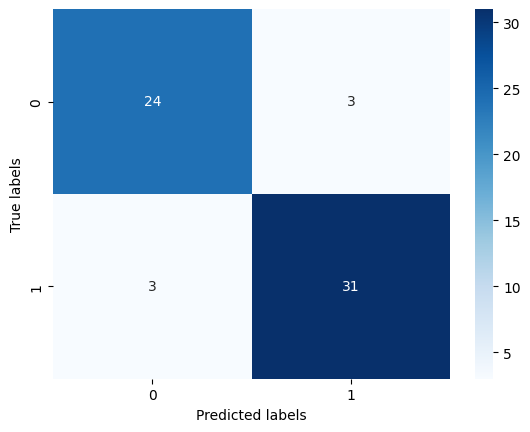

In [530]:
#plot confusion matrix with seaborn blue
import seaborn as sns
import matplotlib.pyplot as plt

# Test loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [531]:
# Print classification report
print(classification_report(y_true, y_pred, target_names=['less', 'more']))


              precision    recall  f1-score   support

        less       0.89      0.89      0.89        27
        more       0.91      0.91      0.91        34

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



# Hand tuning

### Shallow

In [532]:

# Define the model using the best hyperparameters
layers = []
input_size = X_train.shape[1]

layers.append(nn.Linear(input_size, 27*2))
layers.append(nn.ReLU())
layers.append(nn.Linear(27*2, 1))
layers.append(nn.Sigmoid())

model = nn.Sequential(*layers)

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Define the loss function
criterion = nn.BCELoss()

losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    losses_train.append(running_loss / len(train_loader))
    accuracies_train.append(correct / total)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        
        losses_test.append(running_loss / len(test_loader))
        accuracies_test.append(correct / total)


accuracy_r_shallow = accuracies_test.copy()
#plot training and validation loss and accuracy with plotly
import plotly.graph_objects as go

loss_r_shallow = losses_train.copy()
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_train, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_test, mode='lines', name='Validation Accuracy'))

fig.update_layout(
    title='Accuracy Curves',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_train, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_test, mode='lines', name='Validation Loss'))

fig.update_layout(
    title='Loss Curves',
    xaxis_title='Epoch',
    yaxis_title='Loss',
)

fig.show()






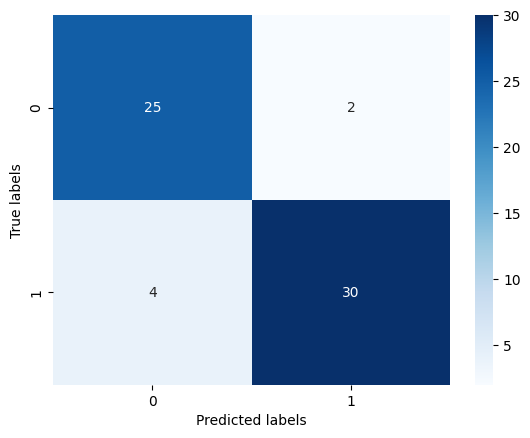

In [533]:

# Test loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [534]:
# Print classification report
print(classification_report(y_true, y_pred, target_names=['less', 'more']))

              precision    recall  f1-score   support

        less       0.86      0.93      0.89        27
        more       0.94      0.88      0.91        34

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



### Deep

In [535]:

# Define the model using the best hyperparameters
layers = []
input_size = X_train.shape[1]

layers.append(nn.Linear(input_size, 10))
layers.append(nn.ReLU())
layers.append(nn.Linear(10, 3))
layers.append(nn.ReLU())
layers.append(nn.Linear(3, 10))
layers.append(nn.ReLU())
layers.append(nn.Linear(10, 1))
layers.append(nn.Sigmoid())

model = nn.Sequential(*layers)

# Define the optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

# Define the loss function
criterion = nn.BCELoss()

losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    losses_train.append(running_loss / len(train_loader))
    accuracies_train.append(correct / total)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        
        losses_test.append(running_loss / len(test_loader))
        accuracies_test.append(correct / total)

accuracy_r_deep = accuracies_test.copy()
#plot training and validation loss and accuracy with plotly
import plotly.graph_objects as go

loss_r_deep = losses_train.copy()

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_train, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=accuracies_test, mode='lines', name='Validation Accuracy'))

fig.update_layout(
    title='Accuracy Curves',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_train, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=losses_test, mode='lines', name='Validation Loss'))

fig.update_layout(
    title='Loss Curves',
    xaxis_title='Epoch',
    yaxis_title='Loss',
)

fig.show()


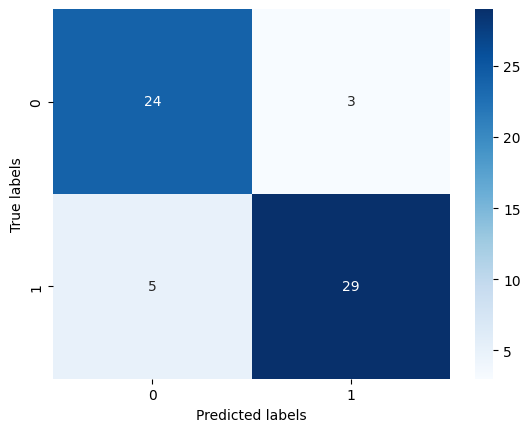

In [536]:

# Test loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [537]:
# Print classification report
print(classification_report(y_true, y_pred, target_names=['less', 'more']))

              precision    recall  f1-score   support

        less       0.83      0.89      0.86        27
        more       0.91      0.85      0.88        34

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [538]:
calculate_metrics(y_true, y_pred, 'nn', rebalanced=True)

Metrics saved to ./results/rebalanced/nn


# Comparison Loss and Validation Accuracy

In [539]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(loss_o_automatic))), y=loss_o_automatic, mode='lines', name='Original Automatic'))
fig.add_trace(go.Scatter(x=list(range(len(loss_o_shallow))), y=loss_o_shallow, mode='lines', name='Original Shallow'))
fig.add_trace(go.Scatter(x=list(range(len(loss_o_deep))), y=loss_o_deep, mode='lines', name='Original Deep'))
fig.add_trace(go.Scatter(x=list(range(len(loss_r_automatic))), y=loss_r_automatic, mode='lines', name='Rebalanced Automatic'))
fig.add_trace(go.Scatter(x=list(range(len(loss_r_shallow))), y=loss_r_shallow, mode='lines', name='Rebalanced Shallow'))
fig.add_trace(go.Scatter(x=list(range(len(loss_r_deep))), y=loss_r_deep, mode='lines', name='Rebalanced Deep'))

fig.update_layout(
    title='Loss Curves',
    xaxis_title='Epoch',
    yaxis_title='Loss',
)

fig.show()

In [540]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(accuracy_o_automatic))), y=accuracy_o_automatic, mode='lines', name='Original Automatic'))
fig.add_trace(go.Scatter(x=list(range(len(accuracy_o_shallow))), y=accuracy_o_shallow, mode='lines', name='Original Shallow'))
fig.add_trace(go.Scatter(x=list(range(len(accuracy_o_deep))), y=accuracy_o_deep, mode='lines', name='Original Deep'))
fig.add_trace(go.Scatter(x=list(range(len(accuracy_r_automatic))), y=accuracy_r_automatic, mode='lines', name='Rebalanced Automatic'))
fig.add_trace(go.Scatter(x=list(range(len(accuracy_r_shallow))), y=accuracy_r_shallow, mode='lines', name='Rebalanced Shallow'))
fig.add_trace(go.Scatter(x=list(range(len(accuracy_r_deep))), y=accuracy_r_deep, mode='lines', name='Rebalanced Deep'))

fig.update_layout(

    title='Accuracy Curves',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
)

fig.show()
